* __Code Objective__   : Build a multi-class classification for to predict sales worthiness of an autombile
* __Author__           : Hemanth Kumar Talla
* __Date of Creation__ : 2nd September, 2018

### Step 1 : Import required libraries and read test and train data set. Append both for data exploration.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from category_encoders.ordinal import OrdinalEncoder

from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

from sklearn.ensemble import RandomForestClassifier

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# Creating a flag for Test and Train Datasets
train['Type'] = 'Train'
test['Type'] = 'Test'

# Combining datasets into one DF for preprocessing
fullData = pd.concat([train, test], axis=0, sort=False)

### Step 2: Explore and summarize the dataset

In [3]:
print('\n', 'fullData.shape:')
print('\n', fullData.shape)
print('*'*99)

print('\n', 'fullData.info():')
print('\n', fullData.info())
print('*'*99)

print('\n', 'fullData.head(5):')
print('\n', fullData.head(5))
print('*'*99)

print('\n', 'fullData.describe():')
print('\n', fullData.describe())
print('*'*99)


 fullData.shape:

 (1728, 8)
***************************************************************************************************

 fullData.info():
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1728 entries, 0 to 345
Data columns (total 8 columns):
purchasing_cost    1728 non-null object
repair_cost        1728 non-null object
windows            1728 non-null object
people             1728 non-null object
space              1728 non-null object
safety             1728 non-null object
label              1382 non-null object
Type               1728 non-null object
dtypes: object(8)
memory usage: 121.5+ KB

 None
***************************************************************************************************

 fullData.head(5):

   purchasing_cost repair_cost windows people   space safety         label  \
0            high   very_high   5more   more  medium    med  unacceptable   
1       very_high      medium       4   more     big    low  unacceptable   
2          medium      m

In [4]:
# Number of records per each label
print('\n', 'fullData.label.value_counts():')
print('\n', fullData.label.value_counts())


 fullData.label.value_counts():

 unacceptable    974
acceptable      298
very_good        56
good             54
Name: label, dtype: int64


##### The class distribution is skewed with most of the data falling in 2('unacceptable', 'acceptable') of the 4 classes. This would naturally result in a classifier with better ability of less acceptaable automobiles more accurately than good ones.

In [5]:
# Frequency of records for each value of each feature
for col in fullData.columns:
    print('\n', fullData[col].value_counts())


 low          439
medium       437
very_high    436
high         416
Name: purchasing_cost, dtype: int64

 high         444
medium       434
low          427
very_high    423
Name: repair_cost, dtype: int64

 4        440
2        435
5more    433
3        420
Name: windows, dtype: int64

 4       588
2       584
more    556
Name: people, dtype: int64

 medium    582
small     574
big       572
Name: space, dtype: int64

 low       581
high      568
med       457
medium    122
Name: safety, dtype: int64

 unacceptable    974
acceptable      298
very_good        56
good             54
Name: label, dtype: int64

 Train    1382
Test      346
Name: Type, dtype: int64


*As far as features are concerned, the distribution of levels is even.*

### Step 3: Identify the a) ID variables b) Target variables c) Categorical Variables d) Numerical Variables e) Other Variables and list out the considered features

In [6]:
id_col = []
target_col = ['label']
num_cols = []
other_cols = ['Type']
cat_cols = list(set(fullData.columns) - set(id_col) - set(target_col) - set(num_cols) - set(other_cols))

features = list(set(list(fullData.columns)) - set(id_col) - set(target_col) - set(other_cols))

print("Features:\n", features)

Features:
 ['people', 'safety', 'windows', 'repair_cost', 'space', 'purchasing_cost']


*Data consists of only categorical variables, all being ordinal type. We'll look for any redundancy in features after label encoding and modify feature list accordingly*

### Step 4 : Identify the variables with missing values and create a flag for those

In [7]:
# List columns with nulls
fullData.isnull().any()

purchasing_cost    False
repair_cost        False
windows            False
people             False
space              False
safety             False
label               True
Type               False
dtype: bool

Data has no missing values amongst the features, including train and test data. We can skip the missing value treatment.

### Step 5 : Create label encoders for categorical variables

In [8]:
### providing custom label mapping, since the categorical variables are ordinal.
### provided data has no missing values, however, Null vlues are handled in the replace_mpap for exceptions.
replace_map = [{'col': 'purchasing_cost', 'mapping': [(None, -1), ('low', 0), ('medium', 1), ('high', 2), ('very_high', 3)]},
               {'col': 'repair_cost', 'mapping': [(None, -1), ('low', 0), ('medium', 1), ('high', 2), ('very_high', 3)]},
               {'col': 'windows', 'mapping': [(None, -1), ('2', 2), ('3', 3), ('4', 4), ('5more', 9)]},
               {'col': 'people', 'mapping': [(None, -1), ('2', 2), ('4', 4), ('more', 9)]},
               {'col': 'space', 'mapping': [(None, -1), ('small', 0), ('medium', 1), ('big', 2)]},
               {'col': 'safety', 'mapping': [(None, -1), ('low', 0), ('med', 1), ('medium', 1), ('high', 2)]},
               {'col': 'label', 'mapping': [(None, -1), ('unacceptable', 0), ('acceptable', 1), ('very_good', 2), ('good', 3)]}]

# Fit OrdinalEncoder to data, then transform it.
encoder = OrdinalEncoder(verbose=0, mapping=replace_map, handle_unknown='ignore')
fullData_encoded = encoder.fit_transform(fullData)

##### Correlation matrix heatmap

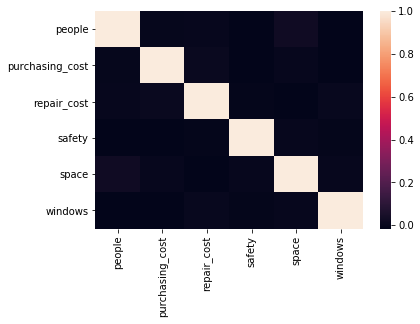

In [9]:
corr = fullData_encoded[fullData_encoded.columns.difference(['label'])].corr()
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

We can notice ther is zero correlation between any two features. 

### Step 6: split the data set to train & test, further split the train data set to train and validate

In [10]:
# Separating data back into train and test
trainVal = fullData_encoded[fullData_encoded['Type']=='Train'].copy()
test = fullData_encoded[fullData_encoded['Type']=='Test'].copy()

# Splitting train data further into train and validate

train, validate = train_test_split(trainVal, test_size=0.2, random_state=3)

print(trainVal.shape)
print(train.shape)
print(validate.shape)
print(test.shape)

(1382, 8)
(1105, 8)
(277, 8)
(346, 8)


In [11]:
x_train = train[features].values
y_train = train['label'].values
x_val = validate[features].values
y_val = validate['label'].values
x_test = test[features].values

In [12]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)

(1105, 6)
(1105,)
(277, 6)
(277,)
(346, 6)


### Step 7 : Load model and fit the data

In [13]:
rf = RandomForestClassifier(n_estimators=1000, random_state=4)
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=4, verbose=0, warm_start=False)

### Step 8 : Evaluate model performance and make predictions

In [14]:
y_score = rf.predict(x_val)

**Accuracy score**

In [15]:
accuracy_score(y_val, y_score)

0.9783393501805054

##### Model accuracy is 98% on validation data. Since the class distribution of data is unbalanced, accuracy is a poor metric.  High score could be a result of just predicting the most frequent class. 

**Confusion Matrix**

In [16]:
# Confusion matrix across label values
cm = confusion_matrix(y_val, y_score, labels=[0, 1, 2, 3])
cm

array([[198,   2,   0,   0],
       [  2,  50,   0,   1],
       [  0,   0,  12,   0],
       [  0,   1,   0,  11]])

*Above confusion matrix shows model performing well for all the classes, despite of heavy data imbalance. The same effect can be seen in precision, recall and F1 score measured label-wise which can be calculated from the consuin matrix. This could be the result of definitive features.*

In [17]:
precision, recall, fscore, support = score(y_val, y_score, labels=[0, 1, 2, 3])

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.99       0.94339623 1.         0.91666667]
recall: [0.99       0.94339623 1.         0.91666667]
fscore: [0.99       0.94339623 1.         0.91666667]
support: [200  53  12  12]


**Multi-class ROC-AUC**

ROC curves are typically used in binary classification to study the output of a classifier. In order to extend ROC curve and ROC area to multi-class or multi-label classification, it is necessary to binarize the output. 

One ROC curve each can be drawn per label, but we can also draw a ROC curve by considering each element of the label indicator matrix as a binary prediction (micro-averaging). Here, we aggregate the contributions of all classes to compute the average metric

Another evaluation measure for multi-class classification is macro-averaging, which gives equal weight to the classification of each label. Macro-average will compute the metric independently for each class and then take the average

In [18]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

labels = fullData.label.dropna().unique()
n_classes = len(labels)

y_val_bi = label_binarize(y_val, classes = [0, 1, 2, 3])
y_score_bi = label_binarize(y_score, classes = [0, 1, 2, 3])

# ROC for each class

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bi[:, i], y_score_bi[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
# 
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bi.ravel(), y_score_bi.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

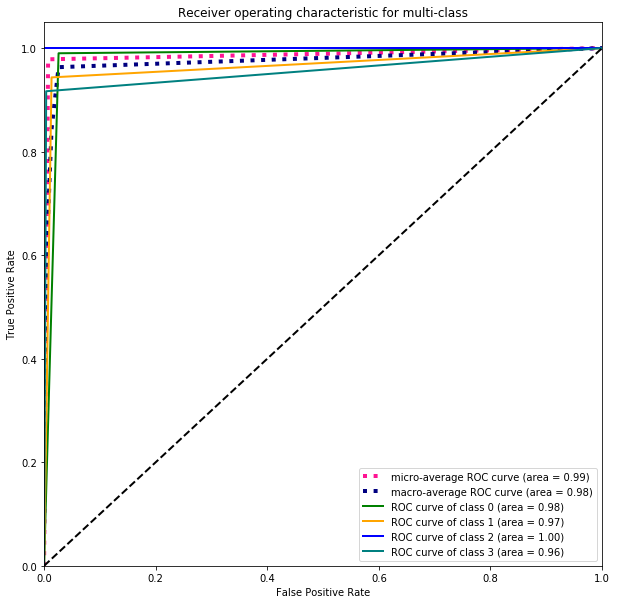

In [19]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

lw = 2
colors = ['green', 'orange', 'blue', 'teal']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()

### Conclusion

##### Even with a highly class-imbalanced data and as few as 1100 records , the Random Forest model we built has resulted in a good model with good precision, recall scores. This could be attributed to decisive features, which is difficult in a real-life scenario. 

### Test Results

In [20]:
predictions = rf.predict(x_test).astype(int)

In [21]:
predictions

array([0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 2, 1, 0, 3, 0, 2, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0,
       3, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 3, 0, 0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 1, 0, 3, 2, 0, 3, 0, 0, 1, 0,
       1, 0, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 2, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 3, 0, 0, 3, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 3, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 2, 1, 1, 1, 0, 1, 0, 1, 1,

In [22]:
output = np.vstack((np.arange(1, 347), predictions)).T

In [23]:
np.savetxt("submission.csv", output, fmt='%d', delimiter=',', header="id, label")